In [1]:
import SimPEG as simpeg
from scipy.constants import mu_0
def omega(freq):
    """Change frequency to angular frequency, omega"""
    return 2.*np.pi*freq

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
np.sum(100*np.cumprod(np.ones(5)*1.6))

   

2529.536000000001

In [4]:
# M = Mesh.TensorMesh([[(100.,32)],[(100.,34)],[(100.,18)]], x0='CCC')
M = simpeg.Mesh.TensorMesh([[(100,5,-1.5),(100.,5),(100,5,1.5)],[(100,5,-1.5),(100.,5),(100,5,1.5)],[(100,5,-1.5),(100.,10),(100,5,1.5)]], x0=['C','C','C'])

In [5]:
print M.vectorNz

[-2478.125 -1718.75  -1212.5    -875.     -650.     -500.     -400.     -300.
  -200.     -100.        0.      100.      200.      300.      400.      500.
   650.      875.     1212.5    1718.75   2478.125]


<matplotlib.colorbar.Colorbar instance at 0x7fcef35a7d40>

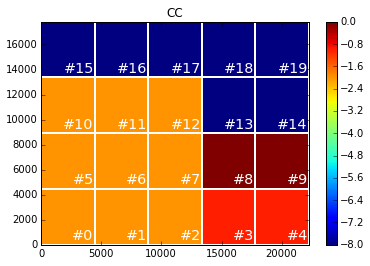

In [6]:
# Setup the model
conds = [1,1e-2]
elev = 300
sig = simpeg.Utils.ModelBuilder.defineBlock(M.gridCC,[-100000,-100000,-200],[100000,100000,0],conds)
sig[M.gridCC[:,2]>elev] = 1e-8
sig[M.gridCC[:,2]<-500] = 1e-1
sig[M.gridCC[:,2]<-900] = 1e-2
# sigBG = np.zeros(M.nC) + conds[0]
# sigBG[M.gridCC[:,2]>0] = 1e-8
sigBG = sig
colorbar(M.plotImage(log10(sig)))

In [7]:
# Get the mass matrix 
# The model
Msig = M.getEdgeInnerProduct(sig)
MsigBG = M.getEdgeInnerProduct(sigBG)
Mmu = M.getFaceInnerProduct(mu_0, invProp=True)

In [8]:
freq = 0.0001
C = M.edgeCurl
A = C.T*Mmu*C - 1j*omega(freq)*Msig
ARH = -(C.T*Mmu*C - 1j*omega(freq)*MsigBG)

In [9]:
%%time
# Solve the systems for each polarization
Ainv = simpeg.SolverLU(A)

CPU times: user 7.68 s, sys: 27.9 ms, total: 7.7 s
Wall time: 7.7 s


In [10]:
# Need to solve x and y polarizations of the source.
from simpegMT.Utils import get1DEfields
# Get a 1d solution for a halfspace background
mesh1d = simpeg.Mesh.TensorMesh([M.hz],np.array([M.x0[2]]))
e0_1d = get1DEfields(mesh1d,M.r(sigBG,'CC','CC','M')[0,0,:],freq,sourceAmp=None).conj()
# Setup the primary field (p) for the x (east) polarization (_px)
ex_px = np.zeros((M.vnEx),dtype=complex)
ey_px = np.zeros(M.nEy,dtype=complex)
ez_px = np.zeros(M.nEz,dtype=complex)
# Assign the source to ex_x
for i in arange(M.vnEx[0]):
    for j in arange(M.vnEx[1]):
        ex_px[i,j,:] = -e0_1d
ep_px = np.r_[simpeg.Utils.mkvc(ex_px),ey_px,ez_px]
rhs_px = ARH.dot(ep_px)

In [11]:
# Setup y (north) polarization (_y)
ex_py = np.zeros(M.nEx, dtype='complex128')
ey_py = np.zeros((M.vnEy), dtype='complex128')
ez_py = np.zeros(M.nEz, dtype='complex128')
# Assign the source to ey_y
for i in arange(M.vnEy[0]):
    for j in arange(M.vnEy[1]):
        ey_py[i,j,:] = e0_1d  
        
ep_py = np.r_[ex_py,simpeg.Utils.mkvc(ey_py),ez_py]
rhs_py = ARH.dot(ep_py)

We are using splu in scipy package. This is bit slow, but on the cluster you can use mumps, which might a lot faster. We can think about having better iterative solver. 

In [12]:
%%time
es_px = Ainv*rhs_px
es_py = Ainv*rhs_py

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 99.4 ms


In [13]:
# Need to sum the ep and es to get the total field.
e_x = es_px #+ ep_px
e_y = es_py #+ ep_py

I want to visualize electrical field, which is a vector, so I average them on to cell center. Also I want to see current density ($\vec{j} = \sigma \vec{e}$).

In [14]:
Meinv = M.getEdgeInnerProduct(np.ones_like(sig), invMat=True)

In [15]:
j_x = Meinv*Msig*e_x
j_y = Meinv*Msig*e_x

In [16]:
e_x.shape

(15200,)

In [17]:
e_x_CC = M.aveE2CCV*e_x
e_y_CC = M.aveE2CCV*e_y
j_x_CC = M.aveE2CCV*j_x
j_y_CC = M.aveE2CCV*j_y
# j_x_CC = Utils.sdiag(np.r_[sig, sig, sig])*e_x_CC

Then use "plotSlice" function, to visualize 2D sections

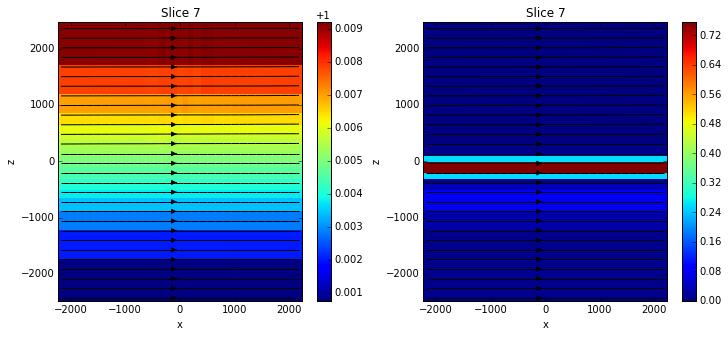

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
dat0 = M.plotSlice(abs(e_x_CC), vType='CCv', view='vec', streamOpts={'color': 'k'}, normal='Y', ax = ax[0])
cb0 = plt.colorbar(dat0[0], ax = ax[0])
dat1 = M.plotSlice(abs(j_x_CC), vType='CCv', view='vec', streamOpts={'color': 'k'}, normal='Y', ax = ax[1])
cb1 = plt.colorbar(dat1[0], ax = ax[1])

Is it reasonable?: Based on that you put resistive target that makes sense to me; current does not want to flow on resistive target so they just do roundabout:). And see air interface. It is continuous on current but not on electric field, which looks reasonable. 

In [19]:
# Calculate the data
rx_x, rx_y = np.meshgrid(np.arange(-500,501,50),np.arange(-500,501,50))
rx_loc = np.hstack((simpeg.Utils.mkvc(rx_x,2),simpeg.Utils.mkvc(rx_y,2),elev+np.zeros((np.prod(rx_x.shape),1))))
# Get the projection matrices
Qex = M.getInterpolationMat(rx_loc,'Ex')
Qey = M.getInterpolationMat(rx_loc,'Ey')
Qez = M.getInterpolationMat(rx_loc,'Ez')
Qfx = M.getInterpolationMat(rx_loc,'Fx')
Qfy = M.getInterpolationMat(rx_loc,'Fy')
Qfz = M.getInterpolationMat(rx_loc,'Fz')

In [20]:
e_x_loc = np.hstack([simpeg.Utils.mkvc(Qex*e_x,2),simpeg.Utils.mkvc(Qey*e_x,2),simpeg.Utils.mkvc(Qez*e_x,2)])
e_y_loc = np.hstack([simpeg.Utils.mkvc(Qex*e_y,2),simpeg.Utils.mkvc(Qey*e_y,2),simpeg.Utils.mkvc(Qez*e_y,2)])
Ciw = -C/(1j*omega(freq)*mu_0)
h_x_loc = np.hstack([simpeg.Utils.mkvc(Qfx*Ciw*e_x,2),simpeg.Utils.mkvc(Qfy*Ciw*e_x,2),simpeg.Utils.mkvc(Qfz*Ciw*e_x,2)])
h_y_loc = np.hstack([simpeg.Utils.mkvc(Qfx*Ciw*e_y,2),simpeg.Utils.mkvc(Qfy*Ciw*e_y,2),simpeg.Utils.mkvc(Qfz*Ciw*e_y,2)])

In [21]:
# Make a combined matrix
dt = np.dtype([('ex1',complex),('ey1',complex),('ez1',complex),('hx1',complex),('hy1',complex),('hz1',complex),('ex2',complex),('ey2',complex),('ez2',complex),('hx2',complex),('hy2',complex),('hz2',complex)])
combMat = np.empty((len(e_x_loc)),dtype=dt)
combMat['ex1'] = e_x_loc[:,0]
combMat['ey1'] = e_x_loc[:,1]
combMat['ez1'] = e_x_loc[:,2]
combMat['ex2'] = e_y_loc[:,0]
combMat['ey2'] = e_y_loc[:,1]
combMat['ez2'] = e_y_loc[:,2]
combMat['hx1'] = h_x_loc[:,0]
combMat['hy1'] = h_x_loc[:,1]
combMat['hz1'] = h_x_loc[:,2]
combMat['hx2'] = h_y_loc[:,0]
combMat['hy2'] = h_y_loc[:,1]
combMat['hz2'] = h_y_loc[:,2]


In [22]:
def calculateImpedance(fieldsData):
    ''' 
    Function that calculates MT impedance data from a rec array with E and H field data from both polarizations
    '''
    zxx = (fieldsData['ex1']*fieldsData['hy2'] - fieldsData['ex2']*fieldsData['hy1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zxy = (-fieldsData['ex1']*fieldsData['hx2'] + fieldsData['ex2']*fieldsData['hx1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zyx = (fieldsData['ey1']*fieldsData['hy2'] - fieldsData['ey2']*fieldsData['hy1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    zyy = (-fieldsData['ey1']*fieldsData['hx2'] + fieldsData['ey2']*fieldsData['hx1'])/(fieldsData['hx1']*fieldsData['hy2'] - fieldsData['hx2']*fieldsData['hy1'])
    return zxx, zxy, zyx, zyy

zxx, zxy, zyx, zyy = calculateImpedance(combMat)

In [23]:
ind = np.where(np.sum(np.power(rx_loc - np.array([0,0,elev]),2),axis=1)< 5)
def appResPhs(freq,z):
    app_res = ((1./(8e-7*np.pi**2))/freq)*np.abs(z)**2
    app_phs = np.arctan2(z.imag,z.real)*(180/np.pi)
    return app_res, app_phs
print appResPhs(freq,zyx[ind])
print appResPhs(freq,zxy[ind])

(array([ 91.22293905]), array([ 42.49194681]))
(array([ 91.22293906]), array([-137.50805341]))


In [24]:
e0_1d = e0_1d.conj()
Qex = mesh1d.getInterpolationMat(np.array([elev]),'Ex')
Qfx = mesh1d.getInterpolationMat(np.array([elev]),'Fx')
h0_1dC = -(mesh1d.nodalGrad*e0_1d)/(1j*omega(freq)*mu_0)
h0_1d = mesh1d.getInterpolationMat(mesh1d.vectorNx,'Ex')*h0_1dC
indSur = np.where(mesh1d.vectorNx==elev)

print (Qfx*e0_1d),(Qex*h0_1dC)#e0_1d, h0_1d
print appResPhs(freq,(Qfx*e0_1d)/(Qex*h0_1dC).conj())

[ 1.00551946-0.00563967j] [ 2776.87342066+2515.31936068j]
(array([ 91.22293906]), array([ 41.84924238]))


In [25]:
import simpegMT as simpegmt
sig1D = M.r(sig,'CC','CC','M')[0,0,:]
anaEd, anaEu, anaHd, anaHu = simpegmt.Utils.MT1Danalytic.getEHfields(mesh1d,sig1D,freq,mesh1d.vectorNx)
anaEtemp = anaEd+anaEu
anaHtemp = anaHd+anaHu
# Scale the solution
anaE = (anaEtemp/anaEtemp[-1])#.conj()
anaH = (anaHtemp/anaEtemp[-1])#.conj()

In [26]:
anaZ = anaE/anaH
indSur = np.where(mesh1d.vectorNx==elev)
print anaZ
print appResPhs(freq,anaZ[indSur])
print appResPhs(freq,-anaZ[indSur])

[ 0.00019869+0.00019869j  0.00019869+0.00019869j  0.00019869+0.00019869j
  0.00019869+0.00019869j  0.00019868+0.0001971j   0.00019867+0.00019605j
  0.00019867+0.00019605j  0.00019867+0.00019605j  0.00019867+0.00019605j
  0.00019842+0.00018849j  0.00019791+0.00018125j  0.00019791+0.00018125j
  0.00019790+0.00018126j  0.00019789+0.00018127j  0.00019789+0.00018135j
  0.00019789+0.00018143j  0.00019789+0.00018154j  0.00019789+0.00018172j
  0.00019789+0.00018199j  0.00019789+0.00018239j  0.00019789+0.00018299j]
(array([ 91.21391269]), array([ 42.48936455]))
(array([ 91.21391269]), array([-137.51063545]))


In [27]:
mesh1d.vectorNx

array([-2478.125, -1718.75 , -1212.5  ,  -875.   ,  -650.   ,  -500.   ,
        -400.   ,  -300.   ,  -200.   ,  -100.   ,     0.   ,   100.   ,
         200.   ,   300.   ,   400.   ,   500.   ,   650.   ,   875.   ,
        1212.5  ,  1718.75 ,  2478.125])